# Check EBL data in Gammapy and in GRB files
Lara provides absorbed flux specturm - we want to check if this is compatible with the gammapy data

In [1]:
import os
os.environ['GAMMAPY_EXTRA'] =r'../../input/gammapy-extra-master'
os.environ['GAMMAPY_DATA'] =r'../../input/gammapy-extra-master/datasets'

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from   astropy.table         import Table
from   astropy.io            import fits

from astropy.visualization import quantity_support

from gammapy.modeling.models import EBLAbsorptionNormSpectralModel
from gammapy.modeling.models import TemplateSpectralModel

## Read a GRB

In [2]:
event_id = 20 # z = 
event_id = 343 # z = 0.13
# event_id = 7 # z= 0.42
# event_id = 676 # z= 2.17
data_dir = "../../input/lightcurves/LONG_FITS/"

In [3]:
filename = data_dir + "Event" + str(event_id)+".fits"
print("Reading data from ",filename)
hdul = fits.open(filename)
Eval     = Table.read(hdul,hdu=2)["Energies (afterglow)"].quantity
Eval     = np.asarray(Eval)*Eval.unit
tval     = Table.read(hdul,hdu=3)["Times (afterglow)"].quantity
tval     = np.asarray(tval)*tval.unit
hdr      = hdul[0].header
redshift = hdr['Z']
print(" Got a GRB at redshift ",redshift)

Reading data from  ../../input/lightcurves/LONG_FITS/Event343.fits
 Got a GRB at redshift  0.131898253436


## Get original and absorbed flux from Lara

In [4]:
# Convert flux table into a numpy array
def get_lara_flux(flux_table,flux_unit = u.Unit("1/(cm2 GeV s)")):
    icol_t = len(flux_table.colnames)          # column number - time
    jrow_E = len(flux_table[flux_table.colnames[0]]) # row number   
    flux   = np.zeros( (icol_t,jrow_E) )*flux_unit
    
    for i in range(0,icol_t):
        for j in range(0,jrow_E):
            flux[i][j] = flux_table[j][i]*flux_unit # transp!
            
    return flux

f_lara     = get_lara_flux(Table.read(hdul,hdu=4)) # Original flux
f_lara_abs = get_lara_flux(Table.read(hdul,hdu=5)) # Absorbed flux

# Read local EBL models

In [5]:
from ebl import EBL_from_file
local_gilmore   = EBL_from_file("data/"+"ebl_gilmore12.dat",debug=True)
local_dominguez = EBL_from_file("data/EBL_abs_RBelmont-dominguez-20170425.dat",debug=True)

 Gilmore from Lara
 Dominguez from Renaud


## Find back EBL model - compare to local Gilmore model

In [6]:
itime = 10 # Choose a time slice
def plot_ratio(E, flux, flux_abs, ax=None,
               max_reduction=1e-3,color="tab:blue",
               label="default",**kwargs):
               
    if (ax == None): fig, ax = plt.subplots()
               
    # remove zeroes from array
    f    = np.array([(1e-18 if x.value==0 else x.value) for x in flux])*flux[0].unit
    fabs = np.array([(1e-18 if x.value==0 else x.value) for x in flux_abs])*flux_abs[0].unit
#     id0  = np.where(flux>0)
#     f    = flux[id0]
#     fabs = flux_abs[id0]
#     E    = E[id0]

    ratio = fabs/f
    for i,r in enumerate(ratio):
        if r>1: print("ratio>1 in bin ",i,":",ratio[ratio>1])
    
    idr = np.where(ratio>max_reduction)
    with quantity_support():
        ax.plot(E[idr],ratio[idr],marker="D",color=color,label=label,**kwargs)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend()
        
    return ax, ratio 

In [7]:
print(range(10,20))

range(10, 20)


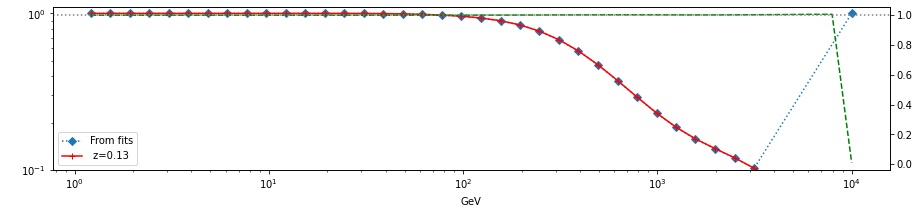

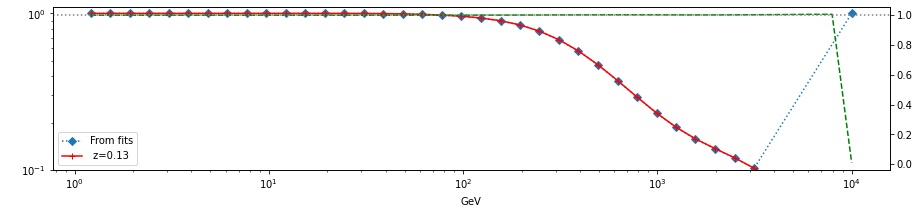

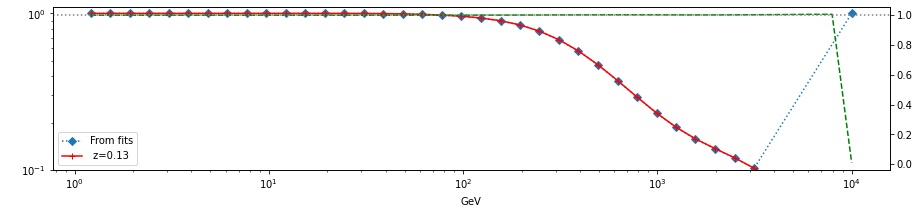

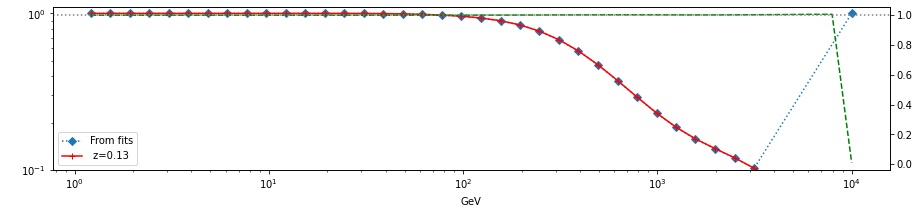

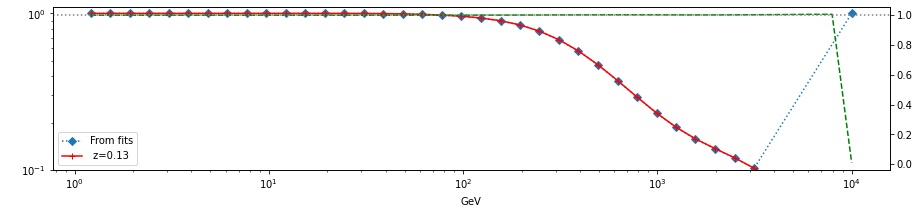

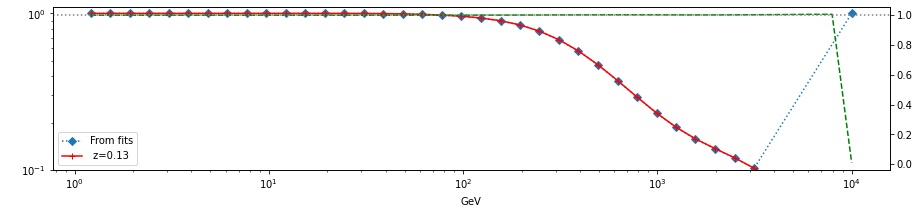

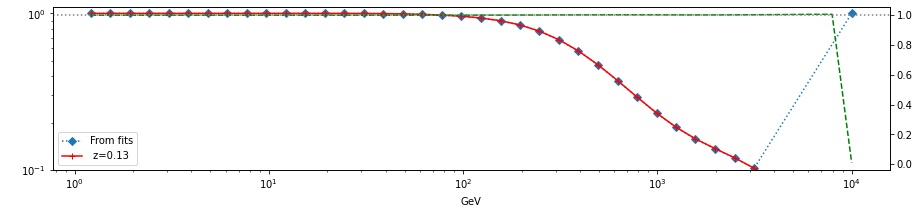

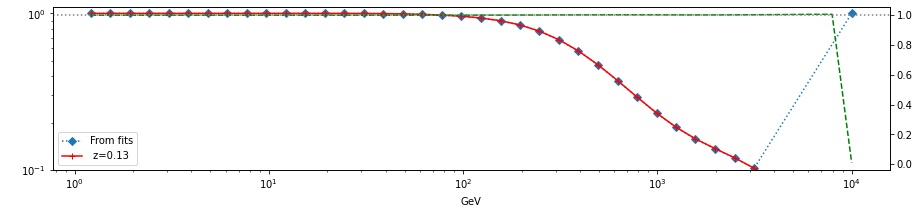

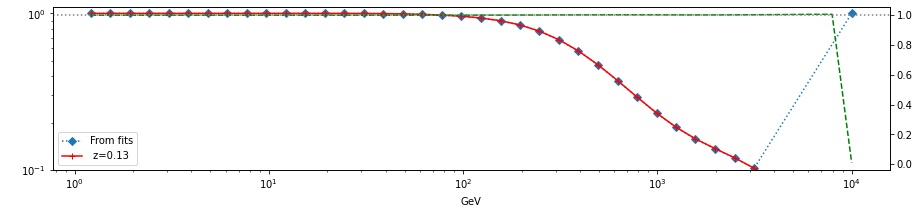

In [8]:
max_reduction = 0.1
for itime in range(30,39):
    fig, ax = plt.subplots(figsize=(15,3))
    ax, ratio_lara = plot_ratio(Eval,f_lara[itime],f_lara_abs[itime],ls=":",label="From fits",
                                ax=ax, max_reduction=max_reduction)

    # The second plot should beperfectly superimposed onthe first one
    from ebl import EBL_plot
    EBL_plot(local_gilmore,zlist=redshift,elist=Eval,color="red",ax=ax,marker="+")
    ax.set_ylim([max_reduction,1.1])
    
    axx=ax.twinx()
    axx.plot(Eval,local_gilmore(Eval,redshift)/ratio_lara,color="green",ls="--")
    axx.axhline(y=1,color="grey",ls=":")
    #   zlist   = np.append([0], np.logspace(np.log10(zmin),np.log10(zmax),nzbin))    
    #     Elist   = np.logspace(np.log10(emin.value),np.log10(emax.to(emin.unit).value),nebin)*emin.unit
    #     taglist = ["gilmore", "dominguez"]
    #     ax = EBL_plot([gilmore, dominguez], tags=taglist, zlist=zlist, elist=Elist)
    #     ax.set_yscale("log")

## Check Gammapy absorption models

In [9]:
dominguez    = EBLAbsorptionNormSpectralModel.read_builtin("dominguez")
franceschini = EBLAbsorptionNormSpectralModel.read_builtin("franceschini")
finke        = EBLAbsorptionNormSpectralModel.read_builtin("finke")

In [25]:
type(Eval)

astropy.units.quantity.Quantity

### Compare Gammapy versus Renaud's data

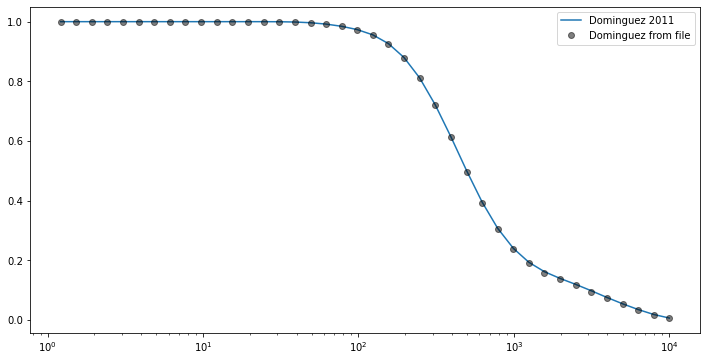

In [38]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(Eval,dominguez.evaluate(Eval,redshift=redshift*u.dimensionless_unscaled,alpha_norm=1) ,label="Dominguez 2011")
ax.plot(Eval,local_dominguez(Eval,redshift),label="Dominguez from file",marker="o",ls="",color="black",alpha=0.5)
ax.set_xscale("log")
ax.legend()

### Compare all absorptions, including local Gilmore

C:\Users\stolar\AppData\Local\Continuum\anaconda3\gpy0.18.2\lib\site-packages\gammapy\modeling\models\spectral.py:405: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx="clip")
C:\Users\stolar\AppData\Local\Continuum\anaconda3\gpy0.18.2\lib\site-packages\gammapy\modeling\models\spectral.py:406: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy="clip")
C:\Users\stolar\AppData\Local\Continuum\anaconda3\gpy0.18.2\lib\site-packages\gammapy\modeling\models\spectral.py:405: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
 

<AxesSubplot:xlabel='Energy [GeV]', ylabel='Norm [A.U.]'>

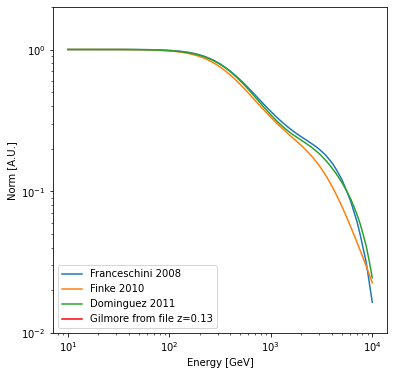

In [12]:
fig, ax = plt.subplots(figsize=(6,6))

energy_range = [10, 10000] * u.GeV
opts = dict(energy_range=energy_range, energy_unit="GeV", flux_unit="", ax=ax)

franceschini.plot(label="Franceschini 2008", **opts)
finke.plot(label="Finke 2010", **opts)
dominguez.plot(label="Dominguez 2011", **opts)

EBL_plot(local_gilmore,zlist=redshift,tags="Gilmore from file",ax=ax,marker="",color="red")
